In [1]:
!pip -q install bert_score bleu rouge_score mlflow datasets

In [2]:
import torch
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments, TrainerCallback, GenerationConfig, set_seed
from sklearn.model_selection import train_test_split
from datasets import load_metric
import mlflow
import mlflow.pytorch
import bert_score
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
train_data = pd.read_json("https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/main/train.json", orient='index')
val_data = pd.read_json("https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/main/dev.json", orient='index')
test_data = pd.read_json("https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/main/test.json", orient='index')

In [4]:
#clean data
train_data = train_data[(train_data['disfluent'].str.len() >= 25)]
val_data = val_data[(val_data['disfluent'].str.len() >= 25)]
test_data = test_data[(test_data['disfluent'].str.len() >= 25)]

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7146 entries, 5a5918ff3e1742001a15cf7e to 5ad405f0604f3c001a3ffe2f
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   original   7146 non-null   object
 1   disfluent  7146 non-null   object
dtypes: object(2)
memory usage: 167.5+ KB


In [7]:
# Augmented Data
train_aug = pd.read_csv('train_augmeneted.csv')
val_aug = pd.read_csv('val_augmeneted.csv')
test_aug = pd.read_csv('test_augmeneted.csv')

In [8]:
train_aug.shape, val_aug.shape, test_aug.shape

((14292, 2), (1990, 2), (7258, 2))

In [9]:
# Define the DisfluencyDataset class (missing in original code)
class DisfluencyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

## BART Experimentation

In [22]:

# Define the trainer class
class BartDisfluencyTrainer:
    def __init__(self, train_df, val_df, test_df, model_name="facebook/bart-base", run_name="BART_Run_4",dropout=0.5,attn_dropout=0.5, seed=42):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.model_name = model_name
        self.run_name = run_name
        self.seed = seed
        self.dropout = dropout
        self.attn_dropout = attn_dropout

        # Set seed for reproducibility
        self.set_seed()



        # Initialize model and tokenizer
        self.model = BartForConditionalGeneration.from_pretrained(self.model_name, dropout=self.dropout,attention_dropout = self.attn_dropout)
        #self.model.config.attention_dropout = self.attn_dropout

        self.tokenizer = BartTokenizer.from_pretrained(self.model_name)

        # Initialize MLflow experiment
        mlflow.set_experiment("Disfluency_Correction_Experiment")

    def set_seed(self):
        set_seed(self.seed)  # Sets seed for Hugging Face's transformers, PyTorch, NumPy, and random.
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)

    def tokenize_data(self, df):
        # Tokenize the disfluent and fluent sentences
        disfluent_encodings = self.tokenizer(df['disfluent'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
        fluent_encodings = self.tokenizer(df['original'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
        disfluent_encodings['labels'] = fluent_encodings['input_ids']
        return disfluent_encodings

    def prepare_datasets(self):
        # Prepare the training and validation datasets
        train_encodings = self.tokenize_data(self.train_df)
        val_encodings = self.tokenize_data(self.val_df)
        return DisfluencyDataset(train_encodings), DisfluencyDataset(val_encodings)

    def train(self):
        # Prepare datasets
        train_dataset, val_dataset = self.prepare_datasets()

        # Set training arguments
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=6,
            per_device_train_batch_size=64,
            per_device_eval_batch_size=64,
            eval_strategy="steps",
            eval_steps=100,
            logging_dir='./logs',
            logging_steps=100,
            save_steps=400,
            save_total_limit=2,
            report_to="none",
            seed=self.seed,
            learning_rate=3e-5,              
            warmup_steps=200,                
            lr_scheduler_type="linear",
            run_name=self.run_name,
            weight_decay=1e-4
        )

        


        # Start an MLflow run and train the model
        with mlflow.start_run():
            mlflow.set_tag("mlflow.runName", self.run_name)

            trainer = Trainer(
                model=self.model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
            )

            # Log hyperparameters to MLflow
            mlflow.log_params({
                "model_name": self.model_name,
                "num_train_epochs": training_args.num_train_epochs,
                "batch_size": training_args.per_device_train_batch_size,
                "eval_batch_size": training_args.per_device_eval_batch_size,
                "learninig_rate":  training_args.learning_rate,
                "weight_decay":  training_args.weight_decay,
                "attention_dropout": self.model.config.attention_dropout,
                "dropout": self.model.config.dropout,
                "seed":  training_args.seed,
                "run_name":  training_args.run_name
            })

            # Train the model
            trainer.train()

            # Log the trained model to MLflow
            mlflow.pytorch.log_model(self.model, "BART_Model_4")

            # Plot and log training loss
            self.plot_and_log_loss(trainer.state.log_history)

            # Generate predictions and log metrics inside the same run
            predictions = self.generate_predictions()
            self.evaluate_and_log_metrics(predictions)

    def plot_and_log_loss(self, logs):
        # Extract training and evaluation losses
        train_losses = [log['loss'] for log in logs if 'loss' in log]
        eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]

        # Plot losses
        plt.figure()
        plt.plot(train_losses, label='Training Loss')
        if eval_losses:
            plt.plot(eval_losses, label='Validation Loss')
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)

        # Save plot
        plot_path = f"{self.run_name}_loss_plot.png"
        plt.savefig(plot_path)

        # Log loss plot as artifact
        mlflow.log_artifact(plot_path)

    def generate_predictions(self, batch_size=32):
        # Generate predictions on the test dataset
        disfluent_texts = self.test_df["disfluent"].tolist()
        predictions = []
    
        # Define the generation configuration
        generation_config = GenerationConfig(
            early_stopping=True,
            num_beams=4,
            no_repeat_ngram_size=3,
            max_length=128
        )
    
        # Process texts in batches
        for i in range(0, len(disfluent_texts), batch_size):
            batch_texts = disfluent_texts[i:i + batch_size]
    
            # Tokenize the batch
            inputs = self.tokenizer(
                batch_texts, 
                return_tensors="pt", 
                max_length=128, 
                truncation=True, 
                padding="max_length"
            ).to(self.model.device)
    
            # Generate predictions with adjusted parameters
            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=inputs["input_ids"], 
                    attention_mask=inputs["attention_mask"], 
                    generation_config=generation_config  # Pass the generation config
                )
    
            # Decode predictions
            batch_predictions = [self.tokenizer.decode(g, skip_special_tokens=True).strip() for g in outputs]
            predictions.extend(batch_predictions)
    
        # Check for empty predictions
        empty_predictions = [pred for pred in predictions if pred.strip() == ""]
        print(f"Number of empty predictions: {len(empty_predictions)}")
    
        return predictions


    def evaluate_and_log_metrics(self, predictions):
        # Evaluate predictions using BLEU, ROUGE, and BERTScore
        fluent_texts = self.test_df["original"].tolist()

        # Compute BLEU score
        tokenized_predictions = [nltk.word_tokenize(pred.lower()) for pred in predictions]
        tokenized_references = [[nltk.word_tokenize(ref.lower())] for ref in fluent_texts]
        bleu_score = load_metric("bleu").compute(predictions=tokenized_predictions, references=tokenized_references)["bleu"]

        # Compute ROUGE score
        rouge_scores = load_metric("rouge").compute(predictions=predictions, references=fluent_texts)

        # Compute BERTScore
        bert_scorer = bert_score.BERTScorer(lang="en", rescale_with_baseline=True)
        _, _, F1 = bert_scorer.score(predictions, fluent_texts)
        bert_f1 = F1.mean().item()

        # Log metrics to MLflow
        mlflow.log_metrics({
            "bleu": bleu_score,
            "rouge1_fmeasure": rouge_scores['rouge1'].mid.fmeasure,
            "rouge2_fmeasure": rouge_scores['rouge2'].mid.fmeasure,
            "rougeL_fmeasure": rouge_scores['rougeL'].mid.fmeasure,
            "bert_score_f1": bert_f1
        })

        # Print to confirm logging of metrics
        print(f"\n\nbleu_score: {bleu_score}\n rouge_scores: {rouge_scores['rougeL'].mid.fmeasure} \n bert_f1: {bert_f1}")
        print("Metrics logged to MLflow successfully.")


## Training BART with orignial dataset

/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024/09/06 19:55:47 INFO mlflow.tracking.fluent: Experiment with name 'Disfluency_Correction_Experiment' does not exist. Creating a new experiment.


Step,Training Loss,Validation Loss
100,1.871900,0.107236
200,0.083600,0.078934
300,0.054600,0.077189
400,0.039000,0.078940
500,0.030000,0.080732


/transformers/src/transformers/modeling_utils.py:2577: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
2024/09/06 19:58:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/06 19:58:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Number of empty predictions: 0


/tmp/ipykernel_6695/4244272994.py:187: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_score = load_metric("bleu").compute(predictions=tokenized_predictions, references=tokenized_references)["bleu"]
/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio



bleu_score: 0.8901177511668159
 rouge_scores: 0.9396827604642554 
 bert_f1: 0.9327864646911621
Metrics logged to MLflow successfully.


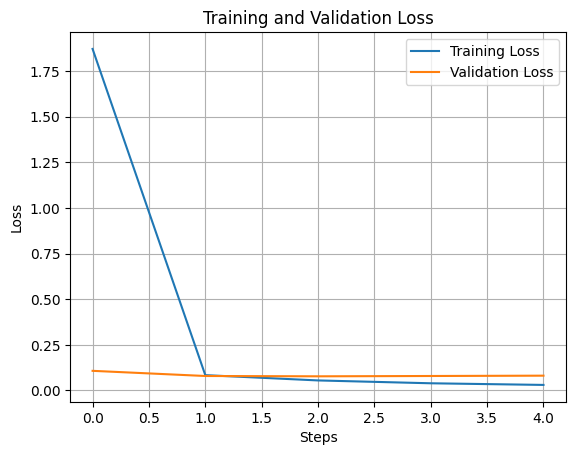

In [14]:
trainer = BartDisfluencyTrainer(train_data, val_data, test_data, seed=42)
trainer.train()

In [15]:
predictions = trainer.generate_predictions()

original_texts = test_data["original"].tolist()
disfluent_texts = test_data["disfluent"].tolist()

result_df = pd.DataFrame({
    "Disfluent": disfluent_texts,
    "Original (Fluent)": original_texts,
    "Predictions (Fluent)": predictions
})

result_df.to_csv('BART_RUN_1.csv')

Number of empty predictions: 0


## Training BART with Augemented Data

### Regularizing
-  adding learning rate:-3e-5
-  adding weight decay: 1e-4

/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Step,Training Loss,Validation Loss
100,7.066400,2.580897
200,1.435000,0.380784
300,0.303100,0.280091
400,0.250700,0.256903
500,0.207900,0.253018
600,0.176400,0.244104
700,0.156300,0.243320
800,0.137100,0.243237
900,0.135300,0.240728
1000,0.117100,0.243387


/transformers/src/transformers/modeling_utils.py:2577: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
2024/09/06 20:16:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/06 20:16:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Number of empty predictions: 0


/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




bleu_score: 0.6442007566818311
 rouge_scores: 0.8173656027731862 
 bert_f1: 0.821088969707489
Metrics logged to MLflow successfully.


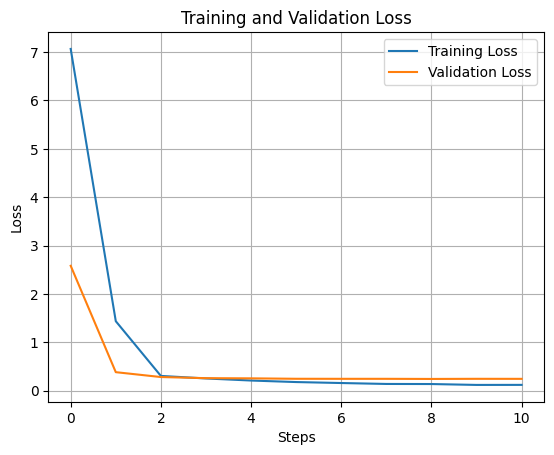

In [17]:
trainer = BartDisfluencyTrainer(train_aug, val_aug, test_aug, seed=42)
trainer.train()

### Regularizing with dropout 
- added dropout of 0.5


/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Step,Training Loss,Validation Loss
100,12.621800,6.966658
200,6.287200,1.680008
300,2.732300,1.536859
400,2.175000,1.485663
500,2.017800,1.321906
600,1.925600,1.220514
700,1.865800,1.080338
800,1.798600,1.023590
900,1.765300,0.990719
1000,1.721600,0.966370


/transformers/src/transformers/modeling_utils.py:2577: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
2024/09/06 20:43:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/06 20:43:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Number of empty predictions: 42


/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




bleu_score: 0.01856579452053758
 rouge_scores: 0.184961962996957 
 bert_f1: 0.1535056084394455
Metrics logged to MLflow successfully.


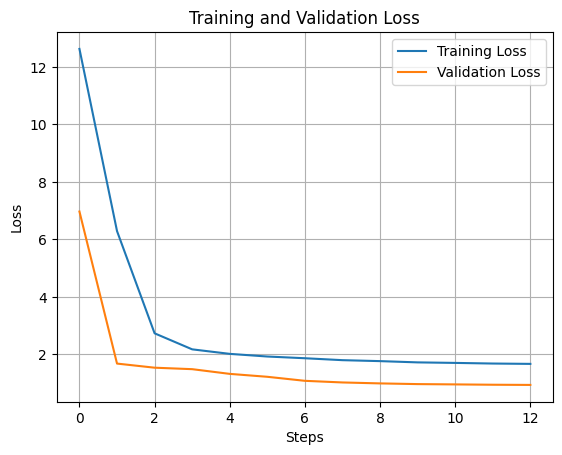

In [23]:
trainer_aug = BartDisfluencyTrainer(train_aug, val_aug, test_aug, seed=42)
trainer_aug.train()

## T5 Experimentation

In [24]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments

In [33]:
# Define the trainer class for T5
class T5Trainer:
    def __init__(self, train_df, val_df, test_df, model_name="t5-small", run_name="T5_Run_2", seed=42):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.model_name = model_name
        self.run_name = run_name
        self.seed = seed

        # Initialize model and tokenizer
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)
        self.tokenizer = T5Tokenizer.from_pretrained(self.model_name)

        # Initialize MLflow experiment
        mlflow.set_experiment("Disfluency_Correction_Experiment")

    def set_seed(self):
        set_seed(self.seed)
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.seed)

    def tokenize_data(self, df):
        # Tokenize the disfluent and fluent sentences
        disfluent_encodings = self.tokenizer(df['disfluent'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
        fluent_encodings = self.tokenizer(df['original'].tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
        disfluent_encodings['labels'] = fluent_encodings['input_ids']
        return disfluent_encodings

    def prepare_datasets(self):
        # Prepare the training and validation datasets
        train_encodings = self.tokenize_data(self.train_df)
        val_encodings = self.tokenize_data(self.val_df)
        return DisfluencyDataset(train_encodings), DisfluencyDataset(val_encodings)

    def train(self):
        # Prepare datasets
        train_dataset, val_dataset = self.prepare_datasets()

        # Set training arguments
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=6,
            per_device_train_batch_size=64,
            per_device_eval_batch_size=64,
            eval_strategy="steps",
            eval_steps=100,
            logging_dir='./logs',
            logging_steps=100,
            save_steps=200,
            save_total_limit=2,
            report_to="none",
            seed=self.seed,
            learning_rate=3e-5,              
            warmup_steps=400,                
            lr_scheduler_type="linear",
            run_name=self.run_name,
            #weight_decay=1e-4
        )

        # Start an MLflow run and train the model
        with mlflow.start_run():
            mlflow.set_tag("mlflow.runName", self.run_name)

            trainer = Trainer(
                model=self.model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
            )

            # Log hyperparameters to MLflow
            mlflow.log_params({
                "model_name": self.model_name,
                "num_train_epochs": training_args.num_train_epochs,
                "batch_size": training_args.per_device_train_batch_size,
                "eval_batch_size": training_args.per_device_eval_batch_size,
                "learning_rate": training_args.learning_rate,
                "warmup_steps": training_args.warmup_steps,
                "run_name": training_args.run_name,
                "seed": training_args.seed,
            })

            # Train the model
            trainer.train()

            # Log the trained model to MLflow
            mlflow.pytorch.log_model(self.model, "T5_Model_2")

            # Plot and log training loss
            self.plot_and_log_loss(trainer.state.log_history)

            # Generate predictions and log metrics inside the same run
            predictions = self.generate_predictions()
            self.evaluate_and_log_metrics(predictions)

    def plot_and_log_loss(self, logs):
        # Extract training and evaluation losses
        train_losses = [log['loss'] for log in logs if 'loss' in log]
        eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]

        # Plot losses
        plt.figure()
        plt.plot(train_losses, label='Training Loss')
        if eval_losses:
            plt.plot(eval_losses, label='Validation Loss')
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)

        # Save plot
        plot_path = f"{self.run_name}_loss_plot.png"
        plt.savefig(plot_path)

        # Log loss plot as artifact
        mlflow.log_artifact(plot_path)

    def generate_predictions(self, batch_size=16):
        # Generate predictions on the test dataset
        disfluent_texts = self.test_df["disfluent"].tolist()
        predictions = []

        # Process texts in batches
        for i in range(0, len(disfluent_texts), batch_size):
            batch_texts = disfluent_texts[i:i + batch_size]

            # Tokenize the batch
            inputs = self.tokenizer(
                batch_texts,
                return_tensors="pt",
                max_length=128,
                truncation=True,
                padding="max_length"
            ).to(self.model.device)

            # Generate predictions with adjusted parameters
            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    max_length=128,
                    num_beams=4,  # Beam search to generate diverse outputs
                    early_stopping=True,
                    no_repeat_ngram_size=2  # Prevent repetitive n-grams
                )

            # Decode predictions
            batch_predictions = [self.tokenizer.decode(g, skip_special_tokens=True).strip() for g in outputs]
            predictions.extend(batch_predictions)

        # Check for empty predictions
        empty_predictions = [pred for pred in predictions if pred.strip() == ""]
        print(f"Number of empty predictions: {len(empty_predictions)}")

        return predictions

    def evaluate_and_log_metrics(self, predictions):
        # Evaluate predictions using BLEU, ROUGE, and BERTScore
        fluent_texts = self.test_df["original"].tolist()

        # Check if all predictions are empty
        if all(pred.strip() == "" for pred in predictions):
            print("All predictions are empty! Skipping BLEU and ROUGE computation.")
            mlflow.log_metrics({
                "bleu": 0,
                "rouge1_fmeasure": 0,
                "rouge2_fmeasure": 0,
                "rougeL_fmeasure": 0,
                "bert_score_f1": 0
            })
            return

        # Compute BLEU score
        tokenized_predictions = [nltk.word_tokenize(pred.lower()) for pred in predictions]
        tokenized_references = [[nltk.word_tokenize(ref.lower())] for ref in fluent_texts]
        bleu_score = load_metric("bleu").compute(predictions=tokenized_predictions, references=tokenized_references)["bleu"]

        # Compute ROUGE score
        rouge_scores = load_metric("rouge").compute(predictions=predictions, references=fluent_texts)

        # Compute BERTScore
        bert_scorer = bert_score.BERTScorer(lang="en", rescale_with_baseline=True)
        _, _, F1 = bert_scorer.score(predictions, fluent_texts)
        bert_f1 = F1.mean().item()

        # Log metrics to MLflow
        mlflow.log_metrics({
            "bleu": bleu_score,
            "rouge1_fmeasure": rouge_scores['rouge1'].mid.fmeasure,
            "rouge2_fmeasure": rouge_scores['rouge2'].mid.fmeasure,
            "rougeL_fmeasure": rouge_scores['rougeL'].mid.fmeasure,
            "bert_score_f1": bert_f1
        })

        # Print to confirm logging of metrics
        print(f"\n\nbleu_score: {bleu_score}\n rouge_scores: {rouge_scores['rougeL'].mid.fmeasure} \n bert_f1: {bert_f1}")
        print("Metrics logged to MLflow successfully.")


## Training T5 with Original dataset

Step,Training Loss,Validation Loss
100,1.689600,0.178223
200,0.182500,0.120228
300,0.141700,0.109641
400,0.128100,0.105612


2024/09/06 20:57:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/06 20:57:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Number of empty predictions: 0


/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




bleu_score: 0.7973653683057658
 rouge_scores: 0.8913863217752955 
 bert_f1: 0.8701449036598206
Metrics logged to MLflow successfully.


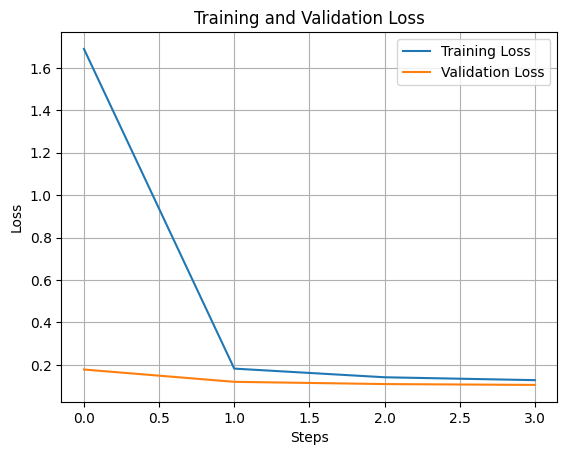

In [30]:
trainer = T5Trainer(train_data, val_data, test_data, seed=42)
trainer.train()

## Training T5 with augmented datset

Step,Training Loss,Validation Loss
100,1.959000,0.198539
200,0.462000,0.147068
300,0.399800,0.129183
400,0.382700,0.122020
500,0.370800,0.114681
600,0.361600,0.112999
700,0.347000,0.110001
800,0.349100,0.109011


2024/09/06 21:09:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/06 21:09:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Number of empty predictions: 0


/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




bleu_score: 0.752045305911592
 rouge_scores: 0.8783404626195099 
 bert_f1: 0.8554674983024597
Metrics logged to MLflow successfully.


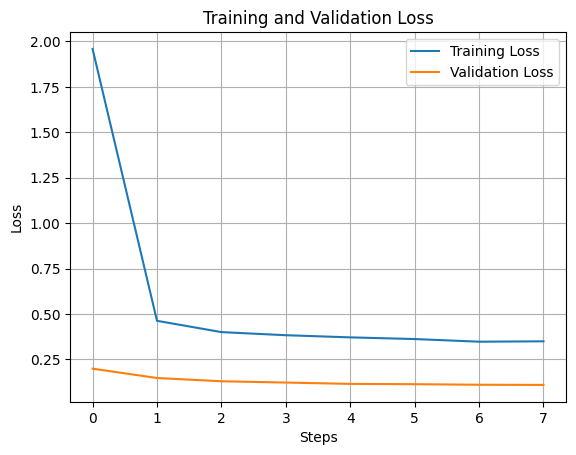

In [32]:
trainer = T5Trainer(train_aug, val_data, test_data, seed=42)
trainer.train()

Step,Training Loss,Validation Loss
100,2.819500,0.786322
200,0.609300,0.437596
300,0.445100,0.402701
400,0.417100,0.385489
500,0.401000,0.374268
600,0.388200,0.365007
700,0.370700,0.359138
800,0.370100,0.355630
900,0.366600,0.350663
1000,0.357100,0.348576


2024/09/06 21:33:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/09/06 21:34:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Number of empty predictions: 0


/transformers/src/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




bleu_score: 0.5508205891352658
 rouge_scores: 0.7797002598823829 
 bert_f1: 0.735930860042572
Metrics logged to MLflow successfully.


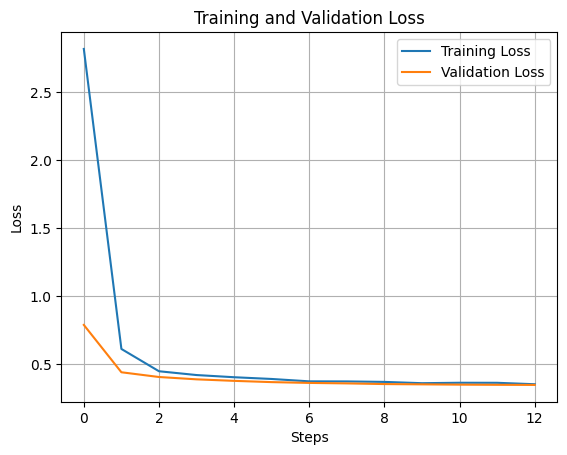

In [34]:
### increasing epochs
trainer = T5Trainer(train_aug, val_aug, test_aug, seed=42)
trainer.train()